In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [2]:
import sklearn

In [3]:
pd.set_option('display.max_columns',None)

## Import cleaned dataset
### Simple model using just Abn% + demographics

In [5]:
pos_final_test = pd.read_csv('../data/pos_KNN_final_test_male.csv.gz', compression='gzip')

non_lab_cols = ['gender', 'age',\
                'ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN',\
                'ed_length', 'insurance_Medicare','insurance_Medicaid'\
               'pneumoia', 'diabetes','hypertension' ,'atherosclero','renal_failure' ,'arrhythmia']
model_cols = pos_final_test.columns.str.contains('max')|pos_final_test.columns.str.contains('min')|pos_final_test.columns.str.contains('abn')|pos_final_test.columns.str.contains('mean') | pos_final_test.columns.str.contains('below') |pos_final_test.columns.str.contains('above') | pos_final_test.columns.isin(non_lab_cols)
hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']

In [14]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# hadm_features['ethnicity'] = le.fit_transform(hadm_features['ethnicity'])
# hadm_features['gender'] = le.fit_transform(hadm_features['gender'])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hadm_features['age'] = scaler.fit_transform(hadm_features['age'].values.reshape(-1, 1))

In [6]:
hadm_features.corr()

,"('min', 'Anion Gap - Blood - Chemistry')","('min', 'Bicarbonate - Blood - Chemistry')","('min', 'Calcium, Total - Blood - Chemistry')","('min', 'Chloride - Blood - Chemistry')","('min', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('min', 'Creatinine - Blood - Chemistry')","('min', 'Estimated GFR (MDRD equation) - Blood - Chemistry')","('min', 'Glucose - Blood - Chemistry')","('min', 'Magnesium - Blood - Chemistry')","('min', 'Phosphate - Blood - Chemistry')","('min', 'Potassium - Blood - Chemistry')","('min', 'Sodium - Blood - Chemistry')","('min', 'Troponin T - Blood - Chemistry')","('min', 'Urea Nitrogen - Blood - Chemistry')","('min', 'Hematocrit - Blood - Hematology')","('min', 'Hemoglobin - Blood - Hematology')","('min', 'MCH - Blood - Hematology')","('min', 'MCHC - Blood - Hematology')","('min', 'MCV - Blood - Hematology')","('min', 'Platelet Count - Blood - Hematology')","('min', 'PT - Blood - Hematology')","('min', 'RDW - Blood - Hematology')","('min', 'Red Blood Cells - Blood - Hematology')","('min', 'White Blood Cells - Blood - Hematology')","('min', 'Bilirubin - Urine - Hematology')","('max', 'Anion Gap - Blood - Chemistry')","('max', 'Bicarbonate - Blood - Chemistry')","('max', 'Calcium, Total - Blood - Chemistry')","('max', 'Chloride - Blood - Chemistry')","('max', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('max', 'Creatinine - Blood - Chemistry')","('max', 'Estimated GFR (MDRD equation) - Blood - Chemistry')","('max', 'Glucose - Blood - Chemistry')","('max', 'Magnesium - Blood - Chemistry')","('max', 'Phosphate - Blood - Chemistry')","('max', 'Potassium - Blood - Chemistry')","('max', 'Sodium - Blood - Chemistry')","('max', 'Troponin T - Blood - Chemistry')","('max', 'Urea Nitrogen - Blood - Chemistry')","('max', 'Hematocrit - Blood - Hematology')","('max', 'Hemoglobin - Blood - Hematology')","('max', 'MCH - Blood - Hematology')","('max', 'MCHC - Blood - Hematology')","('max', 'MCV - Blood - Hematology')","('max', 'Platelet Count - Blood - Hematology')","('max', 'PT - Blood - Hematology')","('max', 'RDW - Blood - Hematology')","('max', 'Red Blood Cells - Blood - Hematology')","('max', 'White Blood Cells - Blood - Hematology')","('max', 'Bilirubin - Urine - Hematology')","('mean', 'Anion Gap - Blood - Chemistry')","('mean', 'Bicarbonate - Blood - Chemistry')","('mean', 'Calcium, Total - Blood - Chemistry')","('mean', 'Chloride - Blood - Chemistry')","('mean', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('mean', 'Creatinine - Blood - Chemistry')","('mean', 'Estimated GFR (MDRD equation) - Blood - Chemistry')","('mean', 'Glucose - Blood - Chemistry')","('mean', 'Magnesium - Blood - Chemistry')","('mean', 'Phosphate - Blood - Chemistry')","('mean', 'Potassium - Blood - Chemistry')","('mean', 'Sodium - Blood - Chemistry')","('mean', 'Troponin T - Blood - Chemistry')","('mean', 'Urea Nitrogen - Blood - Chemistry')","('mean', 'Hematocrit - Blood - Hematology')","('mean', 'Hemoglobin - Blood - Hematology')","('mean', 'MCH - Blood - Hematology')","('mean', 'MCHC - Blood - Hematology')","('mean', 'MCV - Blood - Hematology')","('mean', 'Platelet Count - Blood - Hematology')","('mean', 'PT - Blood - Hematology')","('mean', 'RDW - Blood - Hematology')","('mean', 'Red Blood Cells - Blood - Hematology')","('mean', 'White Blood Cells - Blood - Hematology')","('mean', 'Bilirubin - Urine - Hematology')","('abn_percent', 'Anion Gap - Blood - Chemistry')","('abn_percent', 'Bicarbonate - Blood - Chemistry')","('abn_percent', 'Calcium, Total - Blood - Chemistry')","('abn_percent', 'Chloride - Blood - Chemistry')","('abn_percent', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')","('abn_percent', 'Creatinine - Blood - Chemistry')","('abn_percent', 'Estimated GFR (MDRD equation) - Blood - Chemistry')","('abn_percent', 'Glucose - Blood - Chemistry')","('abn_percent', 'Magnesium - Blood - Chemistry')","('abn_percent', 'Phosphate - Blood - Chemistry')","('abn_percent', 'Potassium - Blood - Chemistry

## Train test split

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [8]:
# Over and under sample the train set
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

In [9]:
# check target counts
print('Target=0: ',hadm_target[hadm_target==0].count())
print('Target=1: ',hadm_target[hadm_target==1].count())

Target=0:  7551
Target=1:  1162


## Functions used in this notebook

In [10]:
def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tROC_AUC score: {roc_auc_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(25))
      
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(25))

In [11]:
def change_threshold(model, threshold_list, X=X_test):
    '''
    Input a model and threshold_list.
    Output scores based on prediction made with threshold list.
    '''
    metrics = pd.DataFrame(columns = ['Threshold','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for threshold in threshold_list:
        prob = model.best_estimator_.predict_proba(X)[:,1]
        pred = np.where(prob>threshold,1,0)


        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)

        metrics = metrics.append({'Threshold':threshold,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
        
    plt.plot(metrics.Threshold, metrics.Recall, label='Recall', color='green')
    plt.plot(metrics.Threshold, metrics.Precision, label='Precision', color='blue')
    plt.plot(metrics.Threshold, metrics.ROC_AUC, label='ROC_AUC', color='red')
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Scores')
    return metrics

In [12]:
def plot_val_curve(estimator, feature, feature_range, X, y):
    '''
    Plots validation curve for an estimator and a feature for a specified feature range.
    Used to determine range of feature to use for hyperparameter tuning for GridSearchCV.
    '''
    train_scores, valid_scores = validation_curve(estimator, 
                                                  X,y,
                                                  feature,
                                                  feature_range, 
                                                  scoring='roc_auc',cv=3)
    plt.plot(feature_range,train_scores)
    plt.plot(feature_range,valid_scores,linestyle='--')
    plt.xlabel(feature)
    plt.ylabel('roc_auc')

In [13]:
def gather_best_features(model_list):
    best_features = pd.DataFrame()

    for model, model_name in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

## Logistic Regression

### Basic

In [14]:
%%time

params ={'C':np.linspace(1e-2,1,20)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log.fit(X_train, y_train)

CPU times: user 3min 31s, sys: 5.98 s, total: 3min 37s
Wall time: 3min 52s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 0.06210526315789474}
Best CV score:  0.8823
Accuracy Score: 78.66%
_______________________________________________
Classification Report:	Precision Score: 35.54%
			Recall Score: 74.14%
			F1 score: 48.04%
			ROC_AUC score: 76.74%
_______________________________________________
Confusion Matrix: 
 [[1199  312]
 [  60  172]]



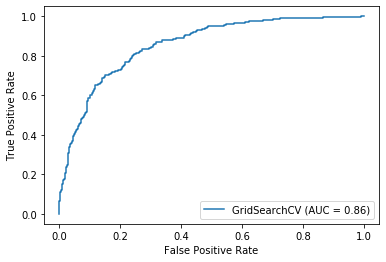

age                                                          0.819471
hypertension                                                 0.548750
gender                                                       0.538845
diabetes                                                     0.434629
('max', 'Phosphate - Blood - Chemistry')                     0.405199
('mean', 'MCHC - Blood - Hematology')                        0.368607
('above_max', 'Phosphate - Blood - Chemistry')               0.347654
('min', 'Urea Nitrogen - Blood - Chemistry')                 0.328511
('below_min', 'Urea Nitrogen - Blood - Chemistry')           0.307091
('mean', 'Chloride - Blood - Chemistry')                     0.302199
('max', 'RDW - Blood - Hematology')                          0.297150
('max', 'Anion Gap - Blood - Chemistry')                     0.265099
('max', 'Potassium - Blood - Chemistry')                     0.256346
('above_max', 'RDW - Blood - Hematology')                    0.253784
('above_max', 'Sodiu

In [15]:
%%time
results(grid_log)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.236438,0.504463,0.995690,0.144005,0.134146
1,0.028163,0.250407,0.540532,0.995690,0.206540,0.143211
2,0.046327,0.264064,0.572129,0.991379,0.264487,0.152318
3,0.064490,0.283600,0.611838,0.991379,0.333333,0.165468
4,0.082653,0.299151,0.639464,0.987069,0.384395,0.176289
5,0.100816,0.314404,0.663281,0.978448,0.432014,0.187294
6,0.118980,0.326769,0.679979,0.965517,0.470453,0.196664
7,0.137143,0.337879,0.694369,0.961207,0.498566,0.204963
8,0.155306,0.349684,0.707928,0.952586,0.528399,0.214147
9,0.173469,0.362438,0.721987,0.948276,0.555938,0.224033


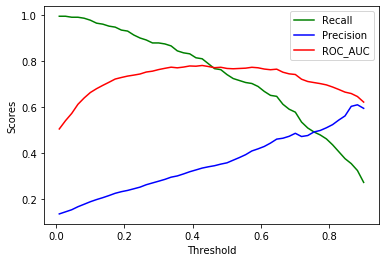

In [16]:
threshold_list = np.linspace(0.01,0.9,50)
change_threshold(grid_log, threshold_list, X_test)

In [17]:
from sklearn.feature_selection import RFECV

selector = RFECV(grid_log.best_estimator_, step=1, cv=5, scoring ='roc_auc')
selector = selector.fit(X_train, y_train)
selector.support_

array([False, False, False, False,  True,  True, False, False, False,
        True,  True, False, False,  True, False, False, False, False,
       False, False,  True, False,  True, False, False,  True,  True,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False,  True,
       False,  True,  True,  True, False,  True, False,  True,  True,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False,  True,  True, False,  True,
        True,  True, False, False, False, False, False, False,  True,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,

In [ ]:
# pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.columns)
# orig_columns=X_train.columns.to_frame().reset_index()[[0]]
# orig_columns[selector.support_]

In [18]:
X_reduced = selector.transform(X_train)
grid_log_reduced = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_reduced.fit(X_reduced, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

In [19]:
est_coefs = pd.Series(grid_log_reduced.best_estimator_.coef_[0], index=X_train.iloc[:,selector.support_].columns)
sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
sortedCoefs[sortedCoefs>0]


age                                                                     0.834984
hypertension                                                            0.606209
diabetes                                                                0.587728
('above_max', 'Troponin T - Blood - Chemistry')                         0.563827
('max', 'Phosphate - Blood - Chemistry')                                0.556479
gender                                                                  0.542706
('max', 'Troponin T - Blood - Chemistry')                               0.525886
atherosclero                                                            0.520805
('above_max', 'Phosphate - Blood - Chemistry')                          0.482878
('max', 'Magnesium - Blood - Chemistry')                                0.411102
('above_max', 'RDW - Blood - Hematology')                               0.400894
ethnicity_BLACK/AFRICAN AMERICAN                                        0.394149
('mean', 'Chloride - Blood -

In [20]:
X_test_reduced = selector.transform(X_test)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.240750,0.516045,0.995690,0.164085,0.136929
1,0.028163,0.259696,0.562372,0.995690,0.244406,0.149321
2,0.046327,0.279635,0.604227,0.991379,0.320138,0.162774
3,0.064490,0.299090,0.639634,0.991379,0.381526,0.176110
4,0.082653,0.313970,0.662619,0.978448,0.430866,0.186985
5,0.100816,0.327246,0.680641,0.965517,0.471601,0.197010
6,0.118980,0.338957,0.694692,0.952586,0.505450,0.206157
7,0.137143,0.351243,0.708581,0.943966,0.535858,0.215764
8,0.155306,0.365000,0.724134,0.943966,0.562823,0.226240
9,0.173469,0.374461,0.732729,0.935345,0.584050,0.234088


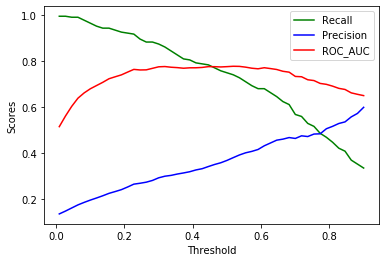

In [21]:
change_threshold(grid_log_reduced, threshold_list,X_test_reduced)

In [24]:
# (2nd round of feature reduction) Remove features with coef 0 and run lasso logistic regression again
X_train_reduced_2 = X_train.loc[:,sortedCoefs[sortedCoefs>0].index]
X_test_reduced_2 = X_test.loc[:,sortedCoefs[sortedCoefs>0].index]
grid_log_reduced_2 = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_reduced_2.fit(X_train_reduced_2, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

In [25]:
grid_log_reduced_2.best_estimator_.get_params

<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=2000, penalty='l1',
                   solver='liblinear')>

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.240750,0.516045,0.995690,0.164085,0.136929
1,0.028163,0.259696,0.562372,0.995690,0.244406,0.149321
2,0.046327,0.279635,0.604227,0.991379,0.320138,0.162774
3,0.064490,0.299090,0.639634,0.991379,0.381526,0.176110
4,0.082653,0.313970,0.662619,0.978448,0.430866,0.186985
5,0.100816,0.327246,0.680641,0.965517,0.471601,0.197010
6,0.118980,0.338957,0.694692,0.952586,0.505450,0.206157
7,0.137143,0.351243,0.708581,0.943966,0.535858,0.215764
8,0.155306,0.365000,0.724134,0.943966,0.562823,0.226240
9,0.173469,0.374461,0.732729,0.935345,0.584050,0.234088


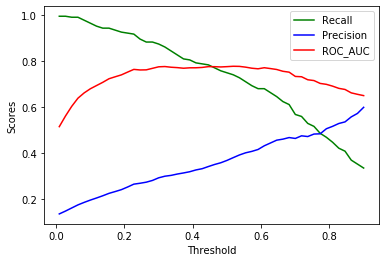

In [26]:
change_threshold(grid_log_reduced_2, threshold_list,X_test_reduced_2)

In [28]:
est_coefs = pd.Series(grid_log_reduced_2.best_estimator_.coef_[0], index=X_train_reduced_2.columns)
sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
# sortedCoefs[sortedCoefs>0]
sortedCoefs.head(50)

age                                                                     0.834989
hypertension                                                            0.606217
gender                                                                  0.605846
diabetes                                                                0.587718
('above_max', 'Troponin T - Blood - Chemistry')                         0.563819
('max', 'Phosphate - Blood - Chemistry')                                0.556480
('max', 'Troponin T - Blood - Chemistry')                               0.525879
atherosclero                                                            0.520817
('above_max', 'Phosphate - Blood - Chemistry')                          0.482863
('max', 'Magnesium - Blood - Chemistry')                                0.411093
('above_max', 'RDW - Blood - Hematology')                               0.400819
ethnicity_BLACK/AFRICAN AMERICAN                                        0.394165
('mean', 'Chloride - Blood -

In [29]:
# (3rd round of feature reduction) Remove features with coef 0 and run lasso logistic regression again
X_train_reduced_3 = X_train.loc[:,sortedCoefs[sortedCoefs>0].index]
X_test_reduced_3 = X_test.loc[:,sortedCoefs[sortedCoefs>0].index]
grid_log_reduced_3 = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_reduced_3.fit(X_train_reduced_3, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

In [30]:
grid_log_reduced_3.best_estimator_.get_params

<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=2000, penalty='l1',
                   solver='liblinear')>

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.240750,0.516045,0.995690,0.164085,0.136929
1,0.028163,0.259696,0.562372,0.995690,0.244406,0.149321
2,0.046327,0.279635,0.604227,0.991379,0.320138,0.162774
3,0.064490,0.299090,0.639634,0.991379,0.381526,0.176110
4,0.082653,0.313970,0.662619,0.978448,0.430866,0.186985
5,0.100816,0.327246,0.680641,0.965517,0.471601,0.197010
6,0.118980,0.338957,0.694692,0.952586,0.505450,0.206157
7,0.137143,0.351243,0.708581,0.943966,0.535858,0.215764
8,0.155306,0.365000,0.724134,0.943966,0.562823,0.226240
9,0.173469,0.374138,0.732398,0.935345,0.583477,0.233836


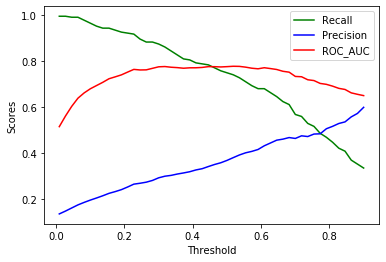

In [31]:
change_threshold(grid_log_reduced_3, threshold_list,X_test_reduced_3)

In [32]:
est_coefs = pd.Series(grid_log_reduced_3.best_estimator_.coef_[0], index=X_train_reduced_3.columns)
sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
# sortedCoefs[sortedCoefs>0]
sortedCoefs

age                                                                     0.834966
gender                                                                  0.645502
hypertension                                                            0.606223
diabetes                                                                0.587730
('above_max', 'Troponin T - Blood - Chemistry')                         0.563741
('max', 'Phosphate - Blood - Chemistry')                                0.556480
('max', 'Troponin T - Blood - Chemistry')                               0.525802
atherosclero                                                            0.520794
('above_max', 'Phosphate - Blood - Chemistry')                          0.482874
('max', 'Magnesium - Blood - Chemistry')                                0.411078
('above_max', 'RDW - Blood - Hematology')                               0.401038
ethnicity_BLACK/AFRICAN AMERICAN                                        0.394148
('mean', 'Chloride - Blood -

In [33]:
sortedCoefs.index

Index(['age', 'gender', 'hypertension', 'diabetes',
       '('above_max', 'Troponin T - Blood - Chemistry')',
       '('max', 'Phosphate - Blood - Chemistry')',
       '('max', 'Troponin T - Blood - Chemistry')', 'atherosclero',
       '('above_max', 'Phosphate - Blood - Chemistry')',
       '('max', 'Magnesium - Blood - Chemistry')',
       '('above_max', 'RDW - Blood - Hematology')',
       'ethnicity_BLACK/AFRICAN AMERICAN',
       '('mean', 'Chloride - Blood - Chemistry')',
       '('min', 'Urea Nitrogen - Blood - Chemistry')',
       '('mean', 'MCHC - Blood - Hematology')',
       '('max', 'RDW - Blood - Hematology')',
       '('below_min', 'Urea Nitrogen - Blood - Chemistry')',
       '('above_max', 'Magnesium - Blood - Chemistry')',
       '('above_max', 'Sodium - Blood - Chemistry')',
       '('max', 'Anion Gap - Blood - Chemistry')',
       '('max', 'Potassium - Blood - Chemistry')',
       '('max', 'Sodium - Blood - Chemistry')',
       '('above_max', 'Anion Gap - Blood - Che

In [34]:
# (4th round of feature reduction) Remove features with coef 0 and run lasso logistic regression again
X_train_reduced_4 = X_train.loc[:,sortedCoefs[sortedCoefs>0].index]
X_test_reduced_4 = X_test.loc[:,sortedCoefs[sortedCoefs>0].index]
grid_log_reduced_4 = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_reduced_4.fit(X_train_reduced_4, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

In [35]:
grid_log_reduced_4.best_estimator_.get_params

<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=2000, penalty='l1',
                   solver='liblinear')>

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.240750,0.516045,0.995690,0.164085,0.136929
1,0.028163,0.259696,0.562372,0.995690,0.244406,0.149321
2,0.046327,0.279635,0.604227,0.991379,0.320138,0.162774
3,0.064490,0.299090,0.639634,0.991379,0.381526,0.176110
4,0.082653,0.313970,0.662619,0.978448,0.430866,0.186985
5,0.100816,0.327246,0.680641,0.965517,0.471601,0.197010
6,0.118980,0.338957,0.694692,0.952586,0.505450,0.206157
7,0.137143,0.351243,0.708581,0.943966,0.535858,0.215764
8,0.155306,0.365000,0.724134,0.943966,0.562823,0.226240
9,0.173469,0.374461,0.732729,0.935345,0.584050,0.234088


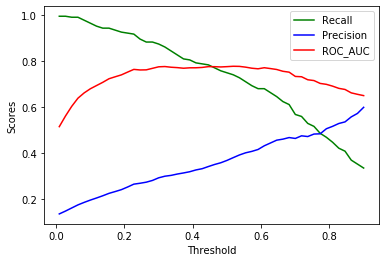

In [36]:
change_threshold(grid_log_reduced_4, threshold_list,X_test_reduced_4)

In [37]:
est_coefs = pd.Series(grid_log_reduced_4.best_estimator_.coef_[0], index=X_train_reduced_4.columns)
sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
# sortedCoefs[sortedCoefs>0]
sortedCoefs

age                                                                     0.834979
gender                                                                  0.705865
hypertension                                                            0.606208
diabetes                                                                0.587722
('above_max', 'Troponin T - Blood - Chemistry')                         0.563414
('max', 'Phosphate - Blood - Chemistry')                                0.556501
('max', 'Troponin T - Blood - Chemistry')                               0.525506
atherosclero                                                            0.520795
('above_max', 'Phosphate - Blood - Chemistry')                          0.482876
('max', 'Magnesium - Blood - Chemistry')                                0.411027
('above_max', 'RDW - Blood - Hematology')                               0.400870
ethnicity_BLACK/AFRICAN AMERICAN                                        0.394144
('mean', 'Chloride - Blood -

### Over Sampling using SMOTE

In [21]:
%%time
params ={'C':np.linspace(1e-2,1,10)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_over = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_over.fit(X_res_over, y_res_over)

CPU times: user 3min 52s, sys: 5.87 s, total: 3min 58s
Wall time: 4min 44s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 1.0}
Best CV score:  0.8978
Accuracy Score: 80.42%
_______________________________________________
Classification Report:	Precision Score: 38.72%
			Recall Score: 72.92%
			F1 score: 50.58%
			ROC_AUC score: 77.27%
_______________________________________________
Confusion Matrix: 
 [[1230  277]
 [  65  175]]



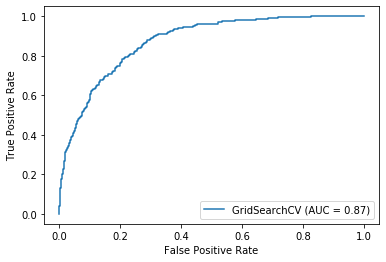

('max', 'Glucose - Blood - Chemistry')                                6.407006
('above_max', 'Glucose - Blood - Chemistry')                          6.239011
('above_max', 'PT - Blood - Hematology')                              2.188717
('max', 'PT - Blood - Hematology')                                    2.047570
('max', 'Magnesium - Blood - Chemistry')                              1.438777
('max', 'Urea Nitrogen - Blood - Chemistry')                          1.404967
('min', 'Red Blood Cells - Blood - Hematology')                       1.378557
('above_max', 'Magnesium - Blood - Chemistry')                        1.312302
('above_max', 'Creatinine - Blood - Chemistry')                       1.233775
('above_max', 'Urea Nitrogen - Blood - Chemistry')                    1.224310
('max', 'Creatinine - Blood - Chemistry')                             1.119029
('above_max', 'Creatine Kinase, MB Isoenzyme - Blood - Chemistry')    1.081700
('mean', 'Red Blood Cells - Blood - Hematology')    

In [22]:
results(grid_log_over)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.259319,0.545123,1.000000,0.215226,0.148976
1,0.064444,0.326162,0.669079,0.979167,0.444190,0.195670
2,0.118889,0.375510,0.728669,0.958333,0.562106,0.233503
3,0.173333,0.410488,0.760906,0.945833,0.626789,0.262125
4,0.227778,0.439801,0.779926,0.920833,0.677733,0.288889
5,0.282222,0.465872,0.792641,0.895833,0.717802,0.314788
6,0.336667,0.478673,0.787456,0.841667,0.748140,0.334437
7,0.391111,0.489899,0.785388,0.808333,0.768746,0.351449
8,0.445556,0.506057,0.787154,0.783333,0.789926,0.373757
9,0.500000,0.505780,0.772679,0.729167,0.804236,0.387168


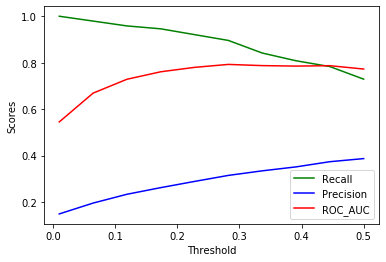

In [105]:
change_threshold(grid_log_over, threshold_list)

### Under Sampling using Near Miss

In [25]:
%%time
params ={'C':np.linspace(1e-2,1,10)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_under = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_under.fit(X_res_under, y_res_under)

CPU times: user 2.81 s, sys: 393 ms, total: 3.21 s
Wall time: 2.22 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 0.12}
Best CV score:  0.9381
Accuracy Score: 70.06%
_______________________________________________
Classification Report:	Precision Score: 29.64%
			Recall Score: 85.83%
			F1 score: 44.06%
			ROC_AUC score: 76.69%
_______________________________________________
Confusion Matrix: 
 [[1018  489]
 [  34  206]]



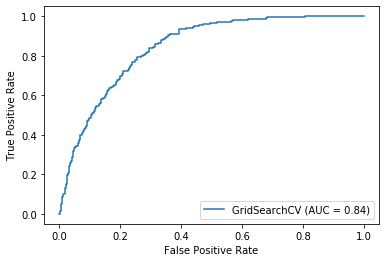

age                                                     1.187974
('min', 'MCHC - Blood - Hematology')                    0.481423
('abn_percent', 'MCH - Blood - Hematology')             0.430324
('min', 'RDW - Blood - Hematology')                     0.415222
('max', 'Potassium - Blood - Chemistry')                0.413900
('min', 'Chloride - Blood - Chemistry')                 0.412841
('abn_percent', 'Bicarbonate - Blood - Chemistry')      0.342297
('above_max', 'Phosphate - Blood - Chemistry')          0.339064
('abn_percent', 'MCHC - Blood - Hematology')            0.324170
gender                                                  0.312435
('mean', 'RDW - Blood - Hematology')                    0.299525
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')    0.299364
('mean', 'Glucose - Blood - Chemistry')                 0.297211
('below_min', 'Hematocrit - Blood - Hematology')        0.261519
('below_min', 'Urea Nitrogen - Blood - Chemistry')      0.259146
('abn_percent', 'Creatini

In [26]:
results(grid_log_under)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.260445,0.547777,1.000000,0.219805,0.149719
1,0.064444,0.309987,0.645229,0.995833,0.390956,0.183564
2,0.118889,0.340580,0.689318,0.979167,0.479107,0.206140
3,0.173333,0.366640,0.720652,0.970833,0.539210,0.225994
4,0.227778,0.382060,0.735636,0.958333,0.574127,0.238589
5,0.282222,0.398601,0.750713,0.950000,0.606182,0.252212
6,0.336667,0.413919,0.763136,0.941667,0.633658,0.265258
7,0.391111,0.424419,0.766137,0.912500,0.659989,0.276515
8,0.445556,0.436290,0.770983,0.891667,0.683457,0.288799
9,0.500000,0.440642,0.766924,0.858333,0.700630,0.296403


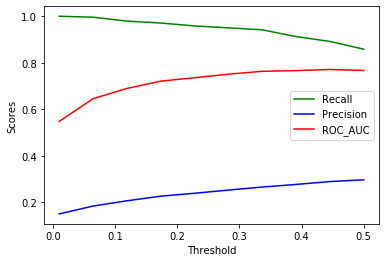

In [106]:
change_threshold(grid_log_under, threshold_list)

## Random Forest

### RF_Over Sampling using SMOTE

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 35, 3) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


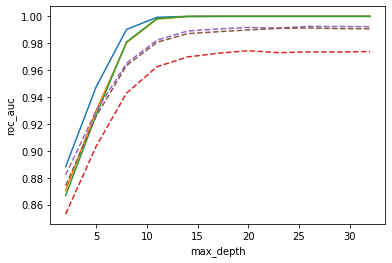

In [27]:
plot_val_curve(RandomForestClassifier(), 'max_depth', range(2,35,3), X_res_over, y_res_over)

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=n_estimators, param_range=range(10, 1000, 100) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


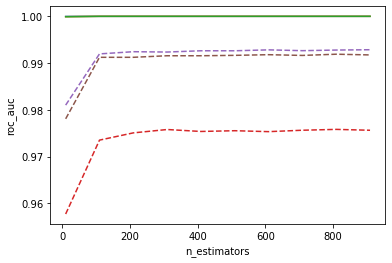

In [30]:
plot_val_curve(RandomForestClassifier(), 'n_estimators', range(10,300,100), X_res_over, y_res_over)

In [31]:
%%time
param_grid={'n_estimators': range(200,201,1),
            'max_depth': range(8,15,3)
            }

grid_rf_over = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_over.fit(X_res_over, y_res_over)

CPU times: user 1min 37s, sys: 2.4 s, total: 1min 39s
Wall time: 1min 53s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(8, 15, 3),
                         'n_estimators': range(200, 201)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 200}
Best CV score:  0.9823
Accuracy Score: 86.55%
_______________________________________________
Classification Report:	Precision Score: 50.97%
			Recall Score: 55.00%
			F1 score: 52.91%
			ROC_AUC score: 73.29%
_______________________________________________
Confusion Matrix: 
 [[1380  127]
 [ 108  132]]



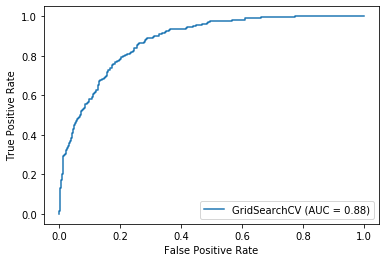

('above_max', 'Urea Nitrogen - Blood - Chemistry')      0.066526
age                                                     0.060393
('max', 'Urea Nitrogen - Blood - Chemistry')            0.044095
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')    0.039905
('mean', 'Urea Nitrogen - Blood - Chemistry')           0.027634
('max', 'Creatinine - Blood - Chemistry')               0.022717
('above_max', 'Creatinine - Blood - Chemistry')         0.022174
('max', 'RDW - Blood - Hematology')                     0.020282
('min', 'Urea Nitrogen - Blood - Chemistry')            0.020236
('abn_percent', 'Creatinine - Blood - Chemistry')       0.019367
('abn_percent', 'Troponin T - Blood - Chemistry')       0.015425
('abn_percent', 'RDW - Blood - Hematology')             0.013857
('above_max', 'RDW - Blood - Hematology')               0.013724
('min', 'MCHC - Blood - Hematology')                    0.013546
('below_min', 'MCHC - Blood - Hematology')              0.011861
('max', 'Bicarbonate - Bl

In [32]:
results(grid_rf_over)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.254912,0.534506,1.000000,0.196909,0.146074
1,0.064444,0.324693,0.668030,0.991667,0.433314,0.194127
2,0.118889,0.383224,0.738900,0.970833,0.570693,0.238730
3,0.173333,0.428980,0.774988,0.937500,0.657127,0.278121
4,0.227778,0.461538,0.790743,0.900000,0.711505,0.310345
5,0.282222,0.493857,0.794994,0.837500,0.764167,0.350174
6,0.336667,0.520280,0.791614,0.775000,0.803663,0.391579
7,0.391111,0.524031,0.773782,0.704167,0.824270,0.417284
8,0.445556,0.524064,0.748519,0.612500,0.847167,0.457944
9,0.500000,0.529058,0.732863,0.550000,0.865484,0.509653


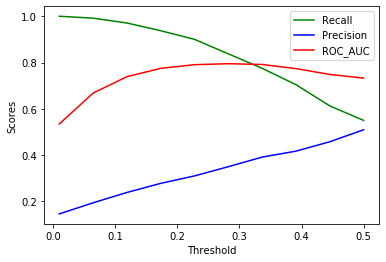

In [107]:
change_threshold(grid_rf_over, threshold_list)

### RF_Under Sampling using Near Miss

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 20, 3) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


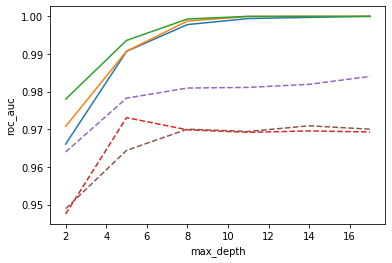

In [33]:
plot_val_curve(RandomForestClassifier(), 'max_depth', range(2,20,3), X_res_under, y_res_under)

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=n_estimators, param_range=range(75, 200, 50) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


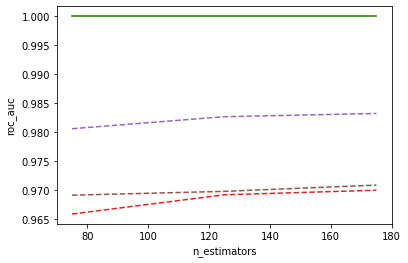

In [35]:
plot_val_curve(RandomForestClassifier(), 'n_estimators', range(75,200,50), X_res_under, y_res_under)

In [36]:
%%time
param_grid={'n_estimators': range(200,201,1),
            'max_depth': range(3,7,1)
            }

grid_rf_under = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_under.fit(X_res_under, y_res_under)

CPU times: user 11.2 s, sys: 248 ms, total: 11.4 s
Wall time: 13.4 s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(3, 7),
                         'n_estimators': range(200, 201)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'max_depth': 6, 'n_estimators': 200}
Best CV score:  0.9728
Accuracy Score: 60.68%
_______________________________________________
Classification Report:	Precision Score: 24.52%
			Recall Score: 89.58%
			F1 score: 38.50%
			ROC_AUC score: 72.83%
_______________________________________________
Confusion Matrix: 
 [[845 662]
 [ 25 215]]



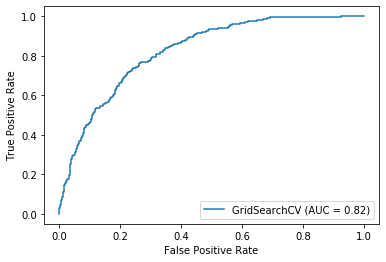

('max', 'Urea Nitrogen - Blood - Chemistry')             0.065703
('min', 'MCHC - Blood - Hematology')                     0.052684
('abn_percent', 'Urea Nitrogen - Blood - Chemistry')     0.051227
('max', 'RDW - Blood - Hematology')                      0.046198
('mean', 'Urea Nitrogen - Blood - Chemistry')            0.045449
('min', 'Chloride - Blood - Chemistry')                  0.036103
('mean', 'RDW - Blood - Hematology')                     0.034542
('above_max', 'Urea Nitrogen - Blood - Chemistry')       0.030805
('abn_percent', 'PT - Blood - Hematology')               0.028155
('min', 'Red Blood Cells - Blood - Hematology')          0.026576
('min', 'Bicarbonate - Blood - Chemistry')               0.025944
('min', 'Hemoglobin - Blood - Hematology')               0.024388
('min', 'Urea Nitrogen - Blood - Chemistry')             0.022430
('mean', 'MCHC - Blood - Hematology')                    0.021614
('below_min', 'Hemoglobin - Blood - Hematology')         0.021539
('max', 'A

In [37]:
results(grid_rf_under)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.241570,0.500000,1.000000,0.137378,0.137378
1,0.064444,0.248062,0.517253,1.000000,0.167144,0.141593
2,0.118889,0.267487,0.563942,0.995833,0.250716,0.154493
3,0.173333,0.286915,0.604088,0.995833,0.319977,0.167602
4,0.227778,0.306214,0.638925,0.995833,0.380080,0.180924
5,0.282222,0.321697,0.662443,0.979167,0.432742,0.192465
6,0.336667,0.338462,0.684634,0.962500,0.483114,0.205333
7,0.391111,0.350932,0.698106,0.941667,0.521465,0.215649
8,0.445556,0.370981,0.720575,0.937500,0.563251,0.231244
9,0.500000,0.384960,0.728275,0.895833,0.606754,0.245154


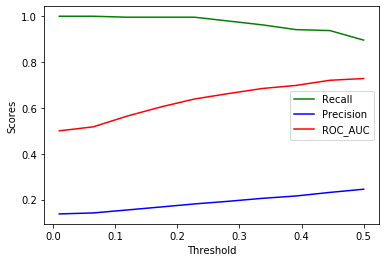

In [108]:
change_threshold(grid_rf_under, threshold_list)

## Gradient Boost

### GB_Over Sampling using SMOTE¶

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(3, 20, 5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


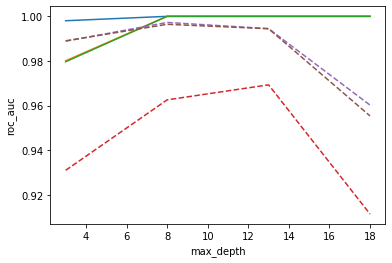

In [38]:
plot_val_curve(GradientBoostingClassifier(), 'max_depth', range(3,20,5), X_res_over, y_res_over)

In [39]:
%%time
param_grid={'n_estimators': range(250,251,1),
            'max_depth': range(8,13,1)
            }

grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid,
                                            cv=3, scoring='roc_auc')
grid_gb_over.fit(X_res_over, y_res_over)

CPU times: user 47min 20s, sys: 44.6 s, total: 48min 5s
Wall time: 53min 22s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(8, 13),
                         'n_estimators': range(250, 251)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'max_depth': 12, 'n_estimators': 250}
Best CV score:  0.9906
Accuracy Score: 88.78%
_______________________________________________
Classification Report:	Precision Score: 65.07%
			Recall Score: 39.58%
			F1 score: 49.22%
			ROC_AUC score: 68.10%
_______________________________________________
Confusion Matrix: 
 [[1456   51]
 [ 145   95]]



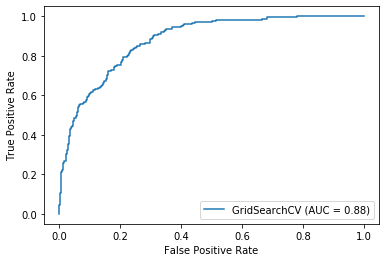

('above_max', 'Urea Nitrogen - Blood - Chemistry')       0.258269
age                                                      0.123486
('max', 'Bicarbonate - Blood - Chemistry')               0.022537
('max', 'Urea Nitrogen - Blood - Chemistry')             0.021536
('abn_percent', 'Troponin T - Blood - Chemistry')        0.016438
('max', 'Anion Gap - Blood - Chemistry')                 0.016137
('max', 'MCHC - Blood - Hematology')                     0.015994
('mean', 'Phosphate - Blood - Chemistry')                0.014801
('below_min', 'MCHC - Blood - Hematology')               0.012987
('min', 'RDW - Blood - Hematology')                      0.011547
('above_max', 'RDW - Blood - Hematology')                0.011483
('abn_percent', 'RDW - Blood - Hematology')              0.011287
('mean', 'Platelet Count - Blood - Hematology')          0.011013
('above_max', 'Creatinine - Blood - Chemistry')          0.010545
('max', 'Magnesium - Blood - Chemistry')                 0.009202
gender    

In [40]:
results(grid_gb_over)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.542435,0.754823,0.612500,0.858042,0.486755
1,0.064444,0.552174,0.733727,0.529167,0.882084,0.577273
2,0.118889,0.534247,0.716875,0.487500,0.883228,0.590909
3,0.173333,0.540793,0.717446,0.483333,0.887235,0.613757
4,0.227778,0.530806,0.710108,0.466667,0.886663,0.615385
5,0.282222,0.519417,0.701351,0.445833,0.886663,0.622093
6,0.336667,0.516129,0.697091,0.433333,0.888380,0.638037
7,0.391111,0.517588,0.696335,0.429167,0.890097,0.651899
8,0.445556,0.508906,0.690749,0.416667,0.889525,0.653595
9,0.500000,0.492228,0.680996,0.395833,0.887808,0.650685


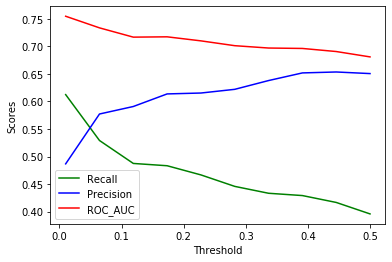

In [109]:
change_threshold(grid_gb_over, threshold_list)

In [237]:
# %%time
# param_grid={'n_estimators':range(150,151,1),
#             'max_depth':range(13,14,1),
# #             'min_samples_split':range(20,100,30),
#             'max_features':range(8,17,2),
#             }
# # 'max_depth': 9, 'n_estimators': 80
# grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
# grid_gb_over.fit(X_res_over, y_res_over)

In [238]:
# results(grid_gb_over)

### GB_Under Sampling using Near Miss

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=range(2, 7) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


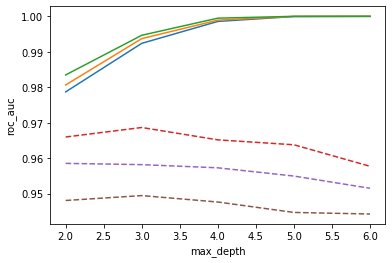

In [240]:
plot_val_curve(GradientBoostingClassifier(), 'max_depth', range(2,7,1),X_res_under, y_res_under)

In [41]:
%%time
param_grid={'n_estimators':range(250,251,1),
            'max_depth':range(2,9,2),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_under.fit(X_res_under, y_res_under)

CPU times: user 2min 11s, sys: 1.04 s, total: 2min 12s
Wall time: 2min 14s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(2, 9, 2),
                         'n_estimators': range(250, 251)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'max_depth': 2, 'n_estimators': 250}
Best CV score:  0.9755
Accuracy Score: 55.52%
_______________________________________________
Classification Report:	Precision Score: 22.46%
			Recall Score: 91.25%
			F1 score: 36.05%
			ROC_AUC score: 70.54%
_______________________________________________
Confusion Matrix: 
 [[751 756]
 [ 21 219]]



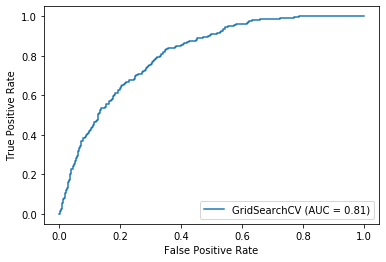

('abn_percent', 'Urea Nitrogen - Blood - Chemistry')    0.276916
('min', 'MCHC - Blood - Hematology')                    0.126682
('max', 'RDW - Blood - Hematology')                     0.091589
('min', 'Chloride - Blood - Chemistry')                 0.065267
('max', 'Urea Nitrogen - Blood - Chemistry')            0.054980
('abn_percent', 'PT - Blood - Hematology')              0.054819
age                                                     0.032455
('mean', 'RDW - Blood - Hematology')                    0.031072
('above_max', 'Calcium, Total - Blood - Chemistry')     0.029929
('max', 'Potassium - Blood - Chemistry')                0.025028
('abn_percent', 'Troponin T - Blood - Chemistry')       0.019214
('min', 'Bicarbonate - Blood - Chemistry')              0.014789
('abn_percent', 'MCH - Blood - Hematology')             0.012157
('max', 'Anion Gap - Blood - Chemistry')                0.011058
('below_min', 'Urea Nitrogen - Blood - Chemistry')      0.010592
('max', 'MCH - Blood - He

In [42]:
results(grid_gb_under)

,Threshold,F1,ROC_AUC,Recall,Accuracy,Precision
0,0.010000,0.241570,0.500000,1.000000,0.137378,0.137378
1,0.064444,0.248062,0.517253,1.000000,0.167144,0.141593
2,0.118889,0.267487,0.563942,0.995833,0.250716,0.154493
3,0.173333,0.286915,0.604088,0.995833,0.319977,0.167602
4,0.227778,0.306214,0.638925,0.995833,0.380080,0.180924
5,0.282222,0.321697,0.662443,0.979167,0.432742,0.192465
6,0.336667,0.338462,0.684634,0.962500,0.483114,0.205333
7,0.391111,0.350932,0.698106,0.941667,0.521465,0.215649
8,0.445556,0.370981,0.720575,0.937500,0.563251,0.231244
9,0.500000,0.384960,0.728275,0.895833,0.606754,0.245154


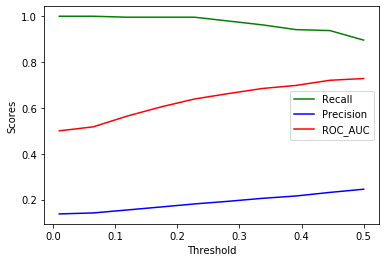

In [110]:
change_threshold(grid_rf_under, threshold_list)

In [241]:
# %%time
# param_grid={'n_estimators':range(80,81,1),
#             'max_depth':range(2,9,2),
# #             'min_samples_split':range(20,100,30),
#             'max_features':range(7,12,2),
#             }

# grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
# grid_gb_under.fit(X_res_under, y_res_under)

In [242]:
# results(grid_gb_under)

## Gather Metrics

In [45]:
def gather_metrics(model_list):
    '''
    Gathers metrics from models in model_list and returns a dataframe of gathered metrics.
    '''
    metrics = pd.DataFrame(columns = ['Model','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for model, model_name in model_list:
        pred = model.best_estimator_.predict(X_test)
        
        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        
        metrics = metrics.append({'Model':model_name,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)
#         print(model_name,' processed')
    return metrics

In [46]:
model_list=[(grid_log,'logistic_basic'),(grid_log_under,'logistic_under'),(grid_log_over,'logistic_over'), 
            (grid_gb_under,'gradient_boost_under'),(grid_gb_over,'gradient_boost_over'),
            (grid_rf_under,'random_forest_under'),(grid_rf_over,'random_forest_over')
           ]
gather_metrics(model_list)

,Model,F1,ROC_AUC,Recall,Accuracy,Precision
0,logistic_basic,0.531609,0.795503,0.770833,0.813394,0.405702
1,logistic_under,0.440642,0.766924,0.858333,0.700630,0.296403
2,logistic_over,0.505780,0.772679,0.729167,0.804236,0.387168
3,gradient_boost_under,0.360494,0.705421,0.912500,0.555238,0.224615
4,gradient_boost_over,0.492228,0.680996,0.395833,0.887808,0.650685
5,random_forest_under,0.384960,0.728275,0.895833,0.606754,0.245154
6,random_forest_over,0.529058,0.732863,0.550000,0.865484,0.509653


## Gather Best Features

In [48]:
gather_best_features(model_list)

,features,logistic_basic,features,logistic_under,features,logistic_over,features,gradient_boost_under,features,gradient_boost_over,features,random_forest_under,features,random_forest_over
0,age,0.760464,age,0.760464,age,0.760464,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.276916,"('above_max', 'Urea Nitrogen - Blood - Chemist...",0.258269,"('max', 'Urea Nitrogen - Blood - Chemistry')",0.065703,"('above_max', 'Urea Nitrogen - Blood - Chemist...",0.066526
1,"('max', 'Bicarbonate - Blood - Chemistry')",0.410612,"('max', 'Bicarbonate - Blood - Chemistry')",0.410612,"('max', 'Bicarbonate - Blood - Chemistry')",0.410612,"('min', 'MCHC - Blood - Hematology')",0.126682,age,0.123486,"('min', 'MCHC - Blood - Hematology')",0.052684,age,0.060393
2,"('above_max', 'RDW - Blood - Hematology')",0.382602,"('above_max', 'RDW - Blood - Hematology')",0.382602,"('above_max', 'RDW - Blood - Hematology')",0.382602,"('max', 'RDW - Blood - Hematology')",0.091589,"('max', 'Bicarbonate - Blood - Chemistry')",0.022537,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.051227,"('max', 'Urea Nitrogen - Blood - Chemistry')",0.044095
3,"('max', 'RDW - Blood - Hematology')",0.365035,"('max', 'RDW - Blood - Hematology')",0.365035,"('max', 'RDW - Blood - Hematology')",0.365035,"('min', 'Chloride - Blood - Chemistry')",0.065267,"('max', 'Urea Nitrogen - Blood - Chemistry')",0.021536,"('max', 'RDW - Blood - Hematology')",0.046198,"('abn_percent', 'Urea Nitrogen - Blood - Chemi...",0.039905
4,"('below_min', 'Urea Nitrogen - Blood - Chemist...",0.307549,"('below_min', 'Urea Nitrogen - Blood - Chemist...",0.307549,"('below_min', 'Urea Nitrogen - Blood - Chemist...",0.307549,"('max', 'Urea Nitrogen - Blood - Chemistry')",0.054980,"('abn_percent', 'Troponin T - Blood - Chemistry')",0.016438,"('mean', 'Urea Nitrogen - Blood - Chemistry')",0.045449,"('mean', 'Urea Nitrogen - Blood - Chemistry')",0.027634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,"('below_min', 'Troponin T - Blood - Chemistry')",0.000000,"('below_min', 'Troponin T - Blood - Chemistry')",0.000000,"('below_min', 'Troponin T - Blood - Chemistry')",0.000000,"('abn_percent', 'Potassium - Blood - Chemistry')",0.000000,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,0.000048,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,0.000000,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,0.000032
148,"('max', 'MCH - Blood - Hematology')",0.000000,"('max', 'MCH - Blood - Hematology')",0.000000,"('max', 'MCH - Blood - Hematology')",0.000000,"('abn_percent', 'Phosphate - Blood - Chemistry')",0.000000,"('below_min', 'Creatine Kinase, MB Isoenzyme -...",0.000000,"('below_min', 'Creatine Kinase, MB Isoenzyme -...",0.000000,"('below_min', 'Bilirubin - Urine - Hematology')",0.000000
149,"('max', 'Hematocrit - Blood - Hematology')",0.000000,"('max', 'Hematocrit - Blood - Hematology')",0.000000,"('max', 'Hematocrit - Blood - Hematology')",0.000000,"('below_min', 'Platelet Count - Blood - Hemato...",0.000000,"('below_min', 'Bilirubin - Urine - Hematology')",0.000000,"('below_min', 'Troponin T - Blood - Chemistry')",0.000000,"('below_min', 'Creatine Kinase, MB Isoenzyme -...",0.000000
150,"('max', 'Urea Nitrogen - Blood - Chemistry')",0.000000,"('max', 'Urea Nitrogen - Blood - Chemistry')",0.000000,"('max', 'Urea Nitrogen - Blood - Chemistry')",0.000000,"('max', 'Chloride - Blood - Chemistry')",0.000000,"('below_min', 'Troponin T - Blood - Chemistry')",0.000000,"('below_min', 'Bilirubin - Urine - Hematology')",0.000000,"('below_min', 'Troponin T - Blood - Chemistry')",0.000000
